In [45]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [46]:
data = pd.read_csv('home/Airline_data.csv')
data.head()

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
0,1976,24,734,3863.0
1,1977,25,516,4300.0
2,1978,31,754,5027.0
3,1979,31,877,5481.0
4,1980,22,814,5814.0


In [47]:
list(data.columns)

['Year', 'Fatal accidents', 'Passenger deaths', 'Miles flown [100 mln miles]']

In [48]:
data.describe()

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
count,10.00000,10.000000,10.000000,10.000000
mean,1980.50000,23.800000,691.900000,5715.800000
std,3.02765,4.709329,252.389228,1117.767795
min,1976.00000,16.000000,223.000000,3863.000000
25%,1978.25000,21.250000,570.500000,5140.500000
50%,1980.50000,23.000000,759.000000,5845.500000
75%,1982.75000,25.750000,812.750000,6175.500000
max,1985.00000,31.000000,1066.000000,7433.000000


In [49]:
# to decrease the exponent 
data['Miles flown [100 mln miles]'] /= 1000
data.head()

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
0,1976,24,734,3.863
1,1977,25,516,4.300
2,1978,31,754,5.027
3,1979,31,877,5.481
4,1980,22,814,5.814


In [50]:
data.describe()

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
count,10.00000,10.000000,10.000000,10.000000
mean,1980.50000,23.800000,691.900000,5.715800
std,3.02765,4.709329,252.389228,1.117768
min,1976.00000,16.000000,223.000000,3.863000
25%,1978.25000,21.250000,570.500000,5.140500
50%,1980.50000,23.000000,759.000000,5.845500
75%,1982.75000,25.750000,812.750000,6.175500
max,1985.00000,31.000000,1066.000000,7.433000


In [51]:
%%writefile home/lab5_prior.stan
generated quantities {
    real alpha = normal_rng(2.38, 1);
    real theta = normal_rng(0.05, 0.01);
    real n = normal_rng(5.71, 1.11);
    real lambda = exp(alpha + theta * n);
    real accidents = poisson_rng(lambda);
}

Overwriting home/lab5_prior.stan


In [52]:
model_ppc=CmdStanModel(stan_file='home/lab5_prior.stan')

INFO:cmdstanpy:compiling stan file /home/lab5_prior.stan to exe file /home/lab5_prior
INFO:cmdstanpy:compiled model executable: /home/lab5_prior


In [53]:
R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=1,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [54]:
df = sim.draws_pd()
df.head()

,lp__,accept_stat__,alpha,theta,n,lambda,accidents
0,0.0,0.0,5.088170,0.057772,4.29778,207.77600,220.0
1,0.0,0.0,-0.184034,0.065516,5.30791,1.17788,2.0
2,0.0,0.0,3.123490,0.056560,5.96541,31.84530,37.0
3,0.0,0.0,1.388710,0.068121,4.28885,5.37022,6.0
4,0.0,0.0,2.599640,0.065748,5.53043,19.36080,22.0


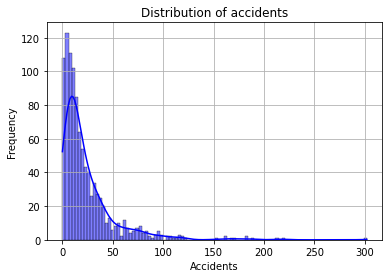

In [55]:
sns.histplot(data=df, x='accidents', bins=100, color='blue', kde=True) # If kde=True, compute a kernel density estimate to smooth the distribution
#df['accidents'].hist(bins=100, density=True)
plt.ylabel("Frequency")
plt.xlabel("Accidents")
plt.title(f"Distribution of accidents")
plt.grid(True)
plt.show()

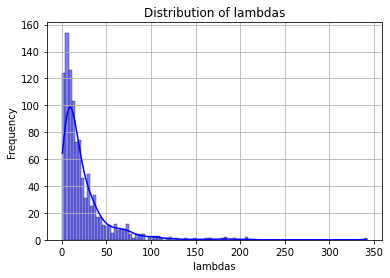

In [56]:
sns.histplot(data=df, x='lambda', bins=100, color='blue', kde=True)
#df['accidents'].hist(bins=100, density=True)
plt.ylabel("Frequency")
plt.xlabel("lambdas")
plt.title(f"Distribution of lambdas")
plt.grid(True)
plt.show()

In [57]:
%%writefile home/lab5_fit.stan
data {
    int<lower=0> N;
    array [N] int<lower=0> accidents;
    vector [N] miles;
}

parameters {
    real alpha;
    real theta;
}

transformed parameters {
    array [N] real lambda;
    for (i in 1:N) {
        lambda[i] = exp(alpha + theta * miles[i]);
    }
}

model {
    alpha ~ normal(2.5, 1);
    theta ~ normal(0.5, 0.1);

    for (i in 1:N) {
        accidents[i] ~ poisson(lambda[i]);
    }
}

generated quantities {
    array [N] int accidents_pred;
    for (i in 1:N) {
        accidents_pred[i] = poisson_rng(lambda[i]);
    }
}


Overwriting home/lab5_fit.stan


In [58]:
fit_model=CmdStanModel(stan_file='home/lab5_fit.stan')

INFO:cmdstanpy:compiling stan file /home/lab5_fit.stan to exe file /home/lab5_fit
INFO:cmdstanpy:compiled model executable: /home/lab5_fit


In [59]:
data_fit = {'N': len(data), 'accidents': data['Fatal accidents'], 'miles': data['Miles flown [100 mln miles]']}
sim=fit_model.sample(data=data_fit, iter_sampling=1000, chains=4, seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [60]:
fit = sim.draws_pd()
fit.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,theta,lambda[1],...,accidents_pred[1],accidents_pred[2],accidents_pred[3],accidents_pred[4],accidents_pred[5],accidents_pred[6],accidents_pred[7],accidents_pred[8],accidents_pred[9],accidents_pred[10]
0,503.498,0.909145,0.156997,2.0,7.0,0.0,-503.180,3.07256,0.030587,24.3057,...,24.0,24.0,23.0,29.0,34.0,23.0,28.0,24.0,19.0,33.0
1,502.057,0.694593,0.156997,1.0,1.0,0.0,-502.016,3.09401,0.036565,25.4129,...,21.0,28.0,17.0,26.0,33.0,32.0,33.0,22.0,33.0,33.0
2,504.103,0.990963,0.156997,1.0,3.0,0.0,-502.151,3.05341,0.024800,23.3176,...,25.0,21.0,29.0,26.0,23.0,26.0,26.0,33.0,21.0,23.0
3,504.376,0.999996,0.156997,4.0,23.0,0.0,-503.603,2.61281,0.095628,19.7315,...,20.0,22.0,23.0,29.0,21.0,25.0,20.0,27.0,26.0,28.0
4,503.656,0.944417,0.156997,3.0,15.0,0.0,-502.947,2.43258,0.117778,17.9494,...,25.0,21.0,25.0,16.0,18.0,26.0,17.0,27.0,30.0,22.0


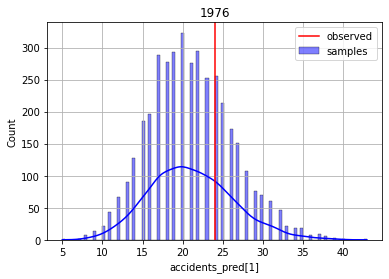

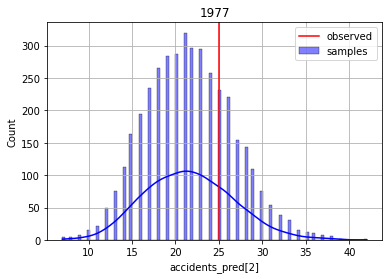

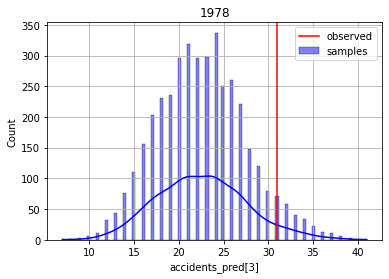

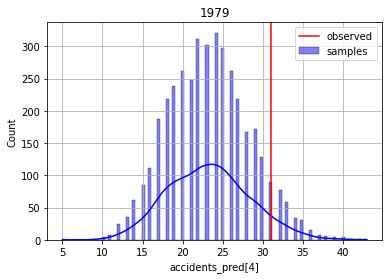

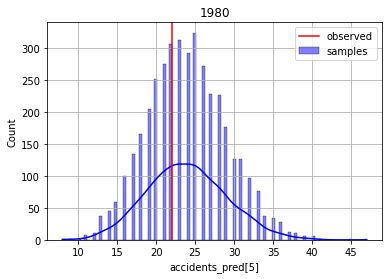

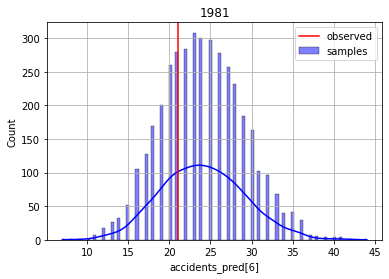

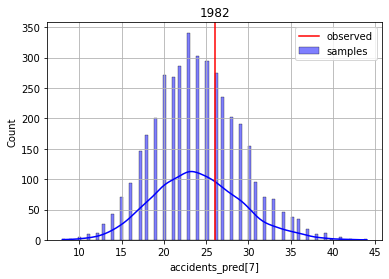

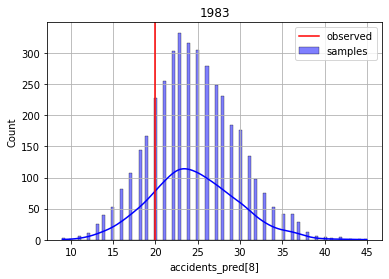

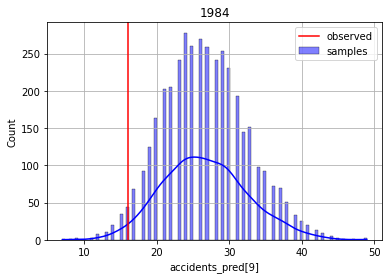

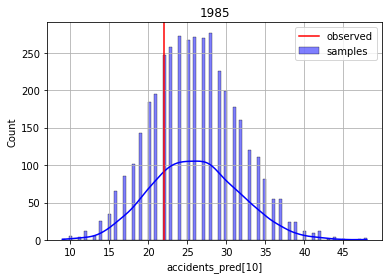

In [61]:
accidents_pred = fit.loc[:, 'accidents_pred[1]':'accidents_pred[10]']
years = data['Year']
observed_fatal_accidents = data['Fatal accidents']
for i in range(len(data)):
    sns.histplot(data=accidents_pred, x=f'accidents_pred[{i+1}]', bins=100, color='blue', kde=True, label='samples')
    plt.axvline(observed_fatal_accidents[i], color='r', label='observed')
    plt.title(f"{years[i]}")
    plt.legend()
    plt.grid()
    plt.show()


In [62]:
%%writefile home/lab5_fit_alpha_i.stan
data {
    int<lower=0> N;
    array [N] int<lower=0> accidents;
    vector [N] miles;
}

parameters {
    array [N] real alpha_i;
    real theta;
}

transformed parameters {
    array [N] real lambda;
    for (i in 1:N) {
        lambda[i] = exp(alpha_i[i] + theta * miles[i]);
    }
}

model {
    alpha_i ~ normal(2.5, 1);
    theta ~ normal(0.5, 0.1);

    for (i in 1:N) {
        accidents[i] ~ poisson(lambda[i]);
    }
}

generated quantities {
    array [N] int accidents_pred;
    for (i in 1:N) {
        accidents_pred[i] = poisson_rng(lambda[i]);
    }
}


Overwriting home/lab5_fit_alpha_i.stan


In [63]:
fit_model_alpha_i=CmdStanModel(stan_file='home/lab5_fit_alpha_i.stan')

INFO:cmdstanpy:compiling stan file /home/lab5_fit_alpha_i.stan to exe file /home/lab5_fit_alpha_i
INFO:cmdstanpy:compiled model executable: /home/lab5_fit_alpha_i


In [64]:
data_fit = {'N': len(data), 'accidents': data['Fatal accidents'], 'miles': data['Miles flown [100 mln miles]']}
sim=fit_model_alpha_i.sample(data=data_fit, iter_sampling=1000, chains=4, seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       


chain 4 |██████████| 00:00 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


In [65]:
fit_alpha = sim.draws_pd()
fit_alpha.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha_i[1],alpha_i[2],alpha_i[3],...,accidents_pred[1],accidents_pred[2],accidents_pred[3],accidents_pred[4],accidents_pred[5],accidents_pred[6],accidents_pred[7],accidents_pred[8],accidents_pred[9],accidents_pred[10]
0,506.474,0.991837,0.215889,4.0,15.0,0.0,-503.179,2.51799,2.62225,2.29023,...,26.0,23.0,24.0,33.0,11.0,18.0,34.0,25.0,30.0,16.0
1,503.756,0.876406,0.215889,5.0,39.0,0.0,-491.050,1.86624,2.30735,1.74873,...,27.0,49.0,29.0,25.0,16.0,21.0,34.0,16.0,33.0,24.0
2,507.668,0.997216,0.215889,3.0,15.0,0.0,-501.056,1.99606,2.03958,1.69143,...,13.0,27.0,16.0,30.0,25.0,18.0,21.0,22.0,28.0,22.0
3,505.922,0.944927,0.215889,4.0,15.0,0.0,-501.532,2.04496,2.02208,2.45385,...,21.0,18.0,32.0,20.0,23.0,22.0,24.0,26.0,11.0,26.0
4,504.187,0.945647,0.215889,4.0,15.0,0.0,-496.253,2.19207,2.28479,2.30143,...,16.0,36.0,34.0,24.0,23.0,15.0,32.0,11.0,11.0,30.0


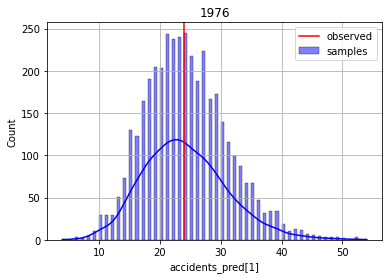

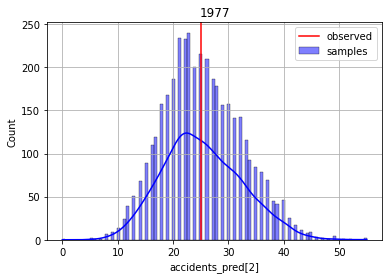

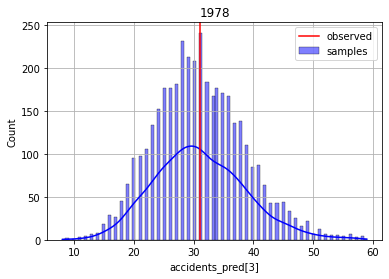

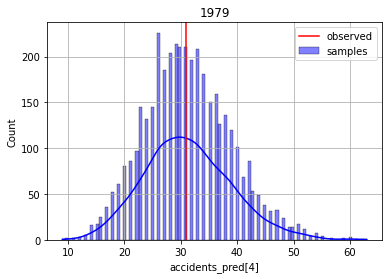

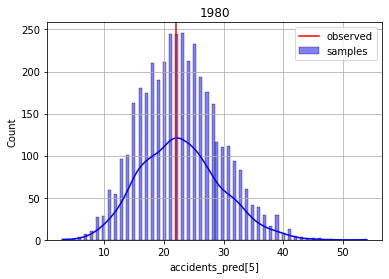

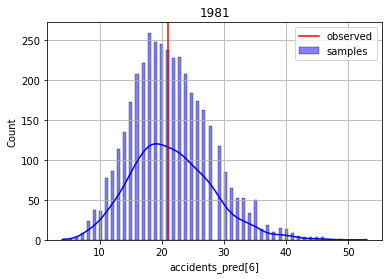

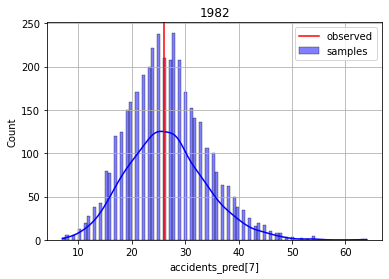

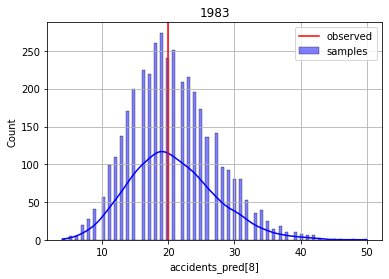

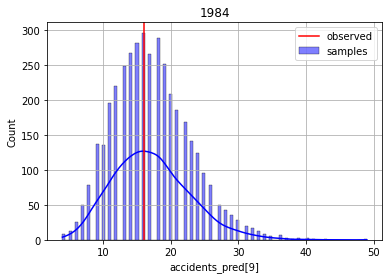

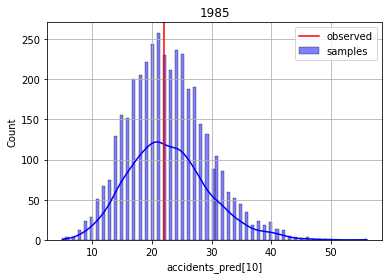

In [66]:
accidents_pred = fit_alpha.loc[:, 'accidents_pred[1]':'accidents_pred[10]']
years = data['Year']
observed_fatal_accidents = data['Fatal accidents']
for i in range(len(data)):
    sns.histplot(data=accidents_pred, x=f'accidents_pred[{i+1}]', bins=100, color='blue', kde=True, label='samples')
    plt.axvline(observed_fatal_accidents[i], color='r', label='observed')
    plt.title(f"{years[i]}")
    plt.legend()
    plt.grid()
    plt.show()

As it is mentioned in the readme for the classes, when we replace the single $\alpha$ intercept with individual intercepts $\alpha_i$ for each year a significiant improvement in model fit is visible.